In [1]:
import pandas as pd
import numpy as np

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import roc_auc_score

# matplotlib and seaborn for plotting
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import normalize
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import MinMaxScaler

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
df_train = pd.read_csv('application_train.csv')
df_test = pd.read_csv('application_test.csv')

In [4]:
bureau = pd.read_csv('bureau.csv')
bureau_balance = pd.read_csv('bureau_balance.csv')
pos_cash_balance = pd.read_csv('POS_CASH_balance.csv')

previous_app = pd.read_csv('previous_application.csv')
installments_payments = pd.read_csv('installments_payments.csv')
credit_card_balance = pd.read_csv('credit_card_balance.csv')

### Слияние данных

In [5]:
print(df_test.shape)

(48744, 121)


In [6]:
def merge_data(df):
    
    df = df.join(bureau.groupby(by='SK_ID_CURR').mean(),
                 how='left', on='SK_ID_CURR', lsuffix='1', rsuffix='2') 
    
    df = df.merge(credit_card_balance.groupby(by='SK_ID_CURR').mean(),
                  on = 'SK_ID_CURR', how = 'left')
    
    df = df.join(previous_app.groupby(by='SK_ID_CURR').mean(),
                 how='left', on='SK_ID_CURR', lsuffix='1', rsuffix='2')    
    
    df = df.join(installments_payments.groupby(by='SK_ID_CURR').mean(),
                 how='left', on='SK_ID_CURR', lsuffix='1', rsuffix='2')   
    
    df = df.join(pos_cash_balance.groupby(by='SK_ID_CURR').mean(),
                 how='left', on='SK_ID_CURR', lsuffix='1', rsuffix='2') 
    
    return df

In [7]:
df_train = merge_data(df_train)
df_test = merge_data(df_test)

In [8]:
print(df_test.shape)

(48744, 188)


### Обзор данных

In [9]:
df_train.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT1,AMT_ANNUITY1,...,DAYS_INSTALMENT,DAYS_ENTRY_PAYMENT,AMT_INSTALMENT,AMT_PAYMENT,SK_ID_PREV2,MONTHS_BALANCE2,CNT_INSTALMENT,CNT_INSTALMENT_FUTURE,SK_DPD2,SK_DPD_DEF2
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,-295.000000,-315.421053,11559.247105,11559.247105,1.038818e+06,-10.000000,24.000000,15.000000,0.0,0.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,-1378.160000,-1385.320000,64754.586000,64754.586000,2.297665e+06,-43.785714,10.107143,5.785714,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,-754.000000,-761.666667,7096.155000,7096.155000,1.564014e+06,-25.500000,3.750000,2.250000,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,-252.250000,-271.625000,62947.088438,62947.088438,2.215853e+06,-9.619048,12.000000,8.650000,0.0,0.0
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,-1028.606061,-1032.242424,12666.444545,12214.060227,2.041993e+06,-33.636364,15.333333,8.969697,0.0,0.0


In [10]:
df_test.head()

,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT1,AMT_ANNUITY1,AMT_GOODS_PRICE1,...,DAYS_INSTALMENT,DAYS_ENTRY_PAYMENT,AMT_INSTALMENT,AMT_PAYMENT,SK_ID_PREV2,MONTHS_BALANCE2,CNT_INSTALMENT,CNT_INSTALMENT_FUTURE,SK_DPD2,SK_DPD_DEF2
0,100001,Cash loans,F,N,Y,0,135000.0,568800.0,20560.5,450000.0,...,-2187.714286,-2195.000000,5885.132143,5885.132143,1.584045e+06,-72.555556,4.000000,1.444444,0.777778,0.777778
1,100005,Cash loans,M,N,Y,0,99000.0,222768.0,17370.0,180000.0,...,-586.000000,-609.555556,6240.205000,6240.205000,2.495675e+06,-20.000000,11.700000,7.200000,0.000000,0.000000
2,100013,Cash loans,M,Y,Y,0,202500.0,663264.0,69777.0,630000.0,...,-1352.929032,-1358.109677,10897.898516,9740.235774,1.582866e+06,-29.555556,21.388889,15.305556,0.944444,0.000000
3,100028,Cash loans,F,N,Y,2,315000.0,1575000.0,49018.5,1575000.0,...,-855.548673,-858.548673,4979.282257,4356.731549,2.655057e+06,-41.967742,20.354839,10.129032,0.000000,0.000000
4,100038,Cash loans,M,Y,N,1,180000.0,625500.0,32067.0,625500.0,...,-622.000000,-634.250000,11100.337500,11100.337500,2.327930e+06,-21.000000,12.000000,5.846154,0.000000,0.000000


### Первичный анализ пропущенных значений

In [11]:
mis_val_percent = (100 * pd.isnull(df_train).sum() / len(df_train)).sort_values(ascending = False)[:15]

In [12]:
mis_val_percent.index

Index(['RATE_INTEREST_PRIMARY', 'RATE_INTEREST_PRIVILEGED',
       'AMT_PAYMENT_CURRENT', 'CNT_DRAWINGS_OTHER_CURRENT',
       'AMT_DRAWINGS_ATM_CURRENT', 'CNT_DRAWINGS_POS_CURRENT',
       'AMT_DRAWINGS_POS_CURRENT', 'AMT_DRAWINGS_OTHER_CURRENT',
       'CNT_DRAWINGS_ATM_CURRENT', 'AMT_ANNUITY2', 'AMT_DRAWINGS_CURRENT',
       'AMT_INST_MIN_REGULARITY', 'AMT_PAYMENT_TOTAL_CURRENT',
       'AMT_RECEIVABLE_PRINCIPAL', 'SK_DPD_DEF1'],
      dtype='object')

In [13]:
for col in mis_val_percent.index:
    if(mis_val_percent[col] > 80):
        del df_train[col]
        del df_test[col]

In [14]:
print(df_train.shape)
df_train = df_train.dropna(thresh=100)
print(df_train.shape)

(307511, 180)
(285555, 180)


### Выделение целевой переменой

In [15]:
answer = pd.DataFrame()
answer['SK_ID_CURR'] = df_test['SK_ID_CURR']

y = df_train['TARGET']
del df_train['TARGET']

del df_test['SK_ID_CURR']
del df_train['SK_ID_CURR']

### Обработка пропущенных значений

In [16]:
df = pd.concat([df_train, df_test])

In [17]:
num_cols = df.select_dtypes(exclude = ["object"]).columns
categ_cols = df.select_dtypes(include = ["object"]).columns

In [18]:
for col in num_cols:
    df[col] = df[col].fillna(df[col].mean())

In [19]:
for col in categ_cols:
    df[col] = df[col].fillna(df[col].mode()[0])

### Корреляция

In [20]:
corr_matrix = df_train[num_cols].corr().abs()

upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
to_drop = [column for column in upper.columns if any(upper[column] > 0.7)]

In [21]:
df = df.drop(to_drop, axis=1)

### Кодирование

In [22]:
def encoder(df):
    scaler = MinMaxScaler()
    numerical = df.select_dtypes(exclude = ["object"]).columns
    features_transform = pd.DataFrame(data= df)
    features_transform[numerical] = scaler.fit_transform(df[numerical])
    display(features_transform.head(n = 5))
    return df

df_norm = encoder(df)

,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT1,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,...,SELLERPLACE_AREA,CNT_PAYMENT,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE,NFLAG_INSURED_ON_APPROVAL,NUM_INSTALMENT_VERSION,AMT_INSTALMENT,SK_DPD2,SK_DPD_DEF2
0,Cash loans,M,N,Y,0.0,0.001512,0.090287,Unaccompanied,Working,Secondary / secondary special,...,0.000125,0.333333,1.0,0.006318,0.007764,0.000000,0.026991,0.004615,0.0,0.0
1,Cash loans,F,N,N,0.0,0.002089,0.311736,Family,State servant,Higher education,...,0.000133,0.138889,1.0,0.004392,0.004968,0.666667,0.026667,0.025854,0.0,0.0
2,Revolving loans,M,Y,Y,0.0,0.000358,0.022472,Unaccompanied,Working,Secondary / secondary special,...,0.000008,0.055556,1.0,0.005723,0.005865,0.000000,0.034188,0.002833,0.0,0.0
3,Cash loans,F,N,Y,0.0,0.000935,0.066837,Unaccompanied,Working,Secondary / secondary special,...,0.000224,0.319444,1.0,0.255226,0.503525,0.000000,0.028846,0.025133,0.0,0.0
4,Cash loans,M,N,Y,0.0,0.000819,0.116854,Unaccompanied,Working,Secondary / secondary special,...,0.000103,0.287037,1.0,0.004422,0.203787,0.600000,0.029915,0.005057,0.0,0.0


In [23]:
df_norm = pd.get_dummies(df_norm)

In [24]:
df_test = df_norm.iloc[df_train.shape[0]:,:]
df_train = df_norm.iloc[:df_train.shape[0],:]

In [25]:
df_train.head()

,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT1,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,...,HOUSETYPE_MODE_terraced house,WALLSMATERIAL_MODE_Block,WALLSMATERIAL_MODE_Mixed,WALLSMATERIAL_MODE_Monolithic,WALLSMATERIAL_MODE_Others,WALLSMATERIAL_MODE_Panel,"WALLSMATERIAL_MODE_Stone, brick",WALLSMATERIAL_MODE_Wooden,EMERGENCYSTATE_MODE_No,EMERGENCYSTATE_MODE_Yes
0,0.0,0.001512,0.090287,0.256702,0.881337,0.045086,0.852140,0.705433,0.131810,1.0,...,0,0,0,0,0,0,1,0,1,0
1,0.0,0.002089,0.311736,0.045506,0.473087,0.043648,0.951929,0.959566,0.131810,1.0,...,0,1,0,0,0,0,0,0,1,0
2,0.0,0.000358,0.022472,0.135340,0.345593,0.046161,0.827335,0.648326,0.285714,1.0,...,0,0,0,0,0,1,0,0,1,0
3,0.0,0.000935,0.066837,0.107480,0.347884,0.038817,0.601451,0.661387,0.131810,1.0,...,0,0,0,0,0,1,0,0,1,0
4,0.0,0.000819,0.116854,0.393191,0.296071,0.038820,0.825268,0.519522,0.131810,1.0,...,0,0,0,0,0,1,0,0,1,0


### Модель. Score: 0.74300

In [26]:
clf = LogisticRegression(random_state=42)

In [27]:
scores = cross_val_score(clf, df_train, y, cv=5, scoring='roc_auc')

In [28]:
scores.mean()

0.7521227585907854

In [29]:
clf = LogisticRegression(random_state=42).fit(df_train, y)

In [30]:
result = clf.predict_proba(df_test)[:,1]

In [31]:
answer['TARGET'] = result

In [32]:
answer.to_csv('4_model.csv', header = True, index = False)

   ### Объединение моделей: 0.73304

In [33]:
out_0 = pd.read_csv('0_model.csv')
out_3 = pd.read_csv('3_model.csv')

In [35]:
result = pd.DataFrame()
result['SK_ID_CURR'] = answer['SK_ID_CURR']
result['TARGET'] = (out_0['TARGET'] + out_0['TARGET']) / 2

In [36]:
result.to_csv('out_mix.csv', index=False, header=True)

### График

In [40]:
my_score = [0.6957, 0.7418, 0.7430, 0.7521, 0.7537]
kaggle_score= [0.69140, 0.73304, 0.7521, 0.7435, 0.74355]

In [41]:
gr = pd.DataFrame({'my_score': my_score,'kaggle_score': kaggle_score})

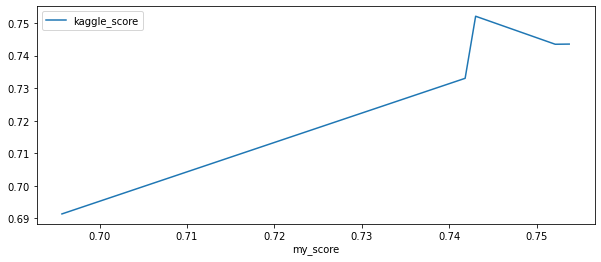

In [42]:
gr.plot(x = 'my_score', y = 'kaggle_score', figsize=(10,4));

### Вывод

Исполльзование predict_proba исправило ошибку и значительно улучшило результаты. При этом, отбор признаков существенного рпироста не дало, видимо в данном случае достаточно обычной предварительной обработки данных.